In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np


In [12]:
#using pretrained model RESNET, source: https://pytorch.org/hub/pytorch_vision_resnet/
model = torch.hub.load('pytorch/vision:v0.4.2', 'resnet18', pretrained=True)

train_on_gpu = torch.cuda.is_available()

classes = ['closed', 'open']

Using cache found in C:\Users\Ahmad/.cache\torch\hub\pytorch_vision_v0.4.2


In [13]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plot = plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [14]:
###########################
# Criterion And Optimizer #
###########################

import torch.optim as optim
# Loss function chosen based on log soft max layer in the model
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
####################
# Making The Model #
####################

# Stop tracking gradients to keep the parameters as it is
for param in model.parameters():
    param.require_grad = False

# edit fc "the last layer in the model" to suit our needs
#the layer has 512 input features
model.fc = nn.Sequential(nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 12),
                                 nn.LogSoftmax(dim=1))
model.load_state_dict(torch.load('trained_model_RESNET18.pt'))
if train_on_gpu:
    model.cuda()

In [16]:
def show(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [19]:
from face import Face

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

face = Face()
eye1, eye2 = face.detect_eyes()
eye1 = cv2.resize(eye1, (224,224), interpolation = cv2.INTER_AREA)
eye2 = cv2.resize(eye2, (224,224), interpolation = cv2.INTER_AREA)

eye1, eye2 = transform(eye1), transform(eye2)
print(eye1.shape)
eyes = [eye1, eye2]
eyes = torch.stack(eyes)
print(eyes.shape)

face found!
eyes found!
torch.Size([3, 224, 224])
torch.Size([2, 3, 224, 224])


[1 1]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
1
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
1


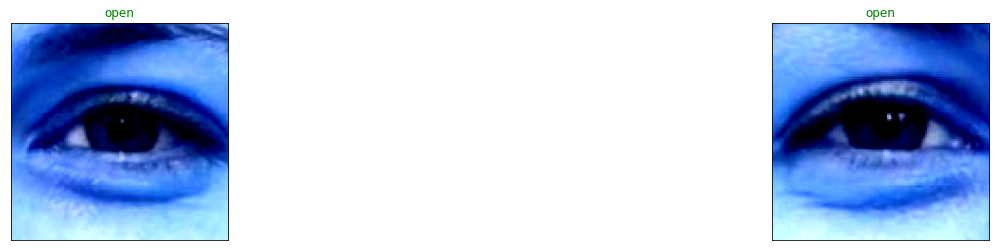

In [21]:
model.eval()
with torch.no_grad():
    #dataiter = iter(testloader)
    #images, labels = dataiter.next()
    eyes = eyes.cpu()
    eyes.numpy()
    
    if train_on_gpu:
        eyes = eyes.cuda()
    output = model(eyes)
    # convert output probabilities to predicted class
    _, predection = torch.max(output, 1)
    # conver the predection tensor into a numpy array
    predection = predection.cpu().numpy() if train_on_gpu else predection.numpy()
    print(predection)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(2):
        ax = fig.add_subplot(1, 2, idx+1, xticks=[], yticks=[])
        imshow(eyes.cpu()[idx])
        print(predection[0])
        ax.set_title("{}".format(classes[predection[idx]]),
                    color=("green"))